# 1) Introduction

In [1]:
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split


data = pd.read_csv("cybersecurity_attacks.csv")
data_proc = data

data_proc = data_proc.drop(columns=["Payload Data","Timestamp","Source IP Address","Destination IP Address","Source Port","Destination Port","Device Information","Proxy Information","User Information","Geo-location Data"])
data_proc["Malware Indicators"].fillna("Not Detected", inplace=True)
data_proc["Alerts/Warnings"].fillna("Not Detected", inplace=True)
data_proc["Firewall Logs"].fillna("Not Detected", inplace=True)
data_proc["IDS/IPS Alerts"].fillna("Not Detected", inplace=True)

data_proc

,Protocol,Packet Length,Packet Type,Traffic Type,Malware Indicators,Anomaly Scores,Alerts/Warnings,Attack Type,Attack Signature,Action Taken,Severity Level,Network Segment,Firewall Logs,IDS/IPS Alerts,Log Source
0,ICMP,503,Data,HTTP,IoC Detected,28.67,Not Detected,Malware,Known Pattern B,Logged,Low,Segment A,Log Data,Not Detected,Server
1,ICMP,1174,Data,HTTP,IoC Detected,51.50,Not Detected,Malware,Known Pattern A,Blocked,Low,Segment B,Log Data,Not Detected,Firewall
2,UDP,306,Control,HTTP,IoC Detected,87.42,Alert Triggered,DDoS,Known Pattern B,Ignored,Low,Segment C,Log Data,Alert Data,Firewall
3,UDP,385,Data,HTTP,Not Detected,15.79,Alert Triggered,Malware,Known Pattern B,Blocked,Medium,Segment B,Not Detected,Alert Data,Firewall
4,TCP,1462,Data,DNS,Not Detected,0.52,Alert Triggered,DDoS,Known Pattern B,Blocked,Low,Segment C,Not Detected,Alert Data,Firewall
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,UDP,1428,Control,HTTP,IoC Detected,39.28,Not Detected,DDoS,Known Pattern A,Logged,Medium,Segment A,Log Data,Alert Data,Firewall
39996,UDP,1184,Control,HTTP,IoC Detected,27.25,Not Detected,DDoS,Known Pattern A,Logged,High,Segment C,Log Data,Not Detected,Firewall
39997,UDP,1043,Data,DNS,IoC Detected,31.01,Not Detected,DDoS,Known Pattern B,Blocked,Low,Segment C,Log Data,Alert Data,Server
39998,UDP,483,Data,FTP,IoC Detected,97.85,Alert Triggered,Malware,Known Pattern B,Ignored,Low,Segment B,Log Data,Not Detected,Server


In [4]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import LabelEncoder

def process_data_x(train, test):
    # Numerical feature in my Dataset
    numerical_idx = ["Packet Length", "Anomaly Scores"]
    
    # convert numeric integer to float and concat them with already float feature 
     # There are no NaN element in these feature
    X_train = pd.concat([pd.to_numeric(train[numerical_idx[0]],downcast='float'), train[numerical_idx[1]]], axis=1)
    
    oneHot_idx = train.columns.drop(['Packet Length', 'Anomaly Scores','Severity Level'])
    
    oh = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    ord = OrdinalEncoder(categories=[['Low','Medium','High']])
    
    ord_encoded = ord.fit_transform(train[['Severity Level']])
    oneHot_encoded = oh.fit_transform(train[oneHot_idx])
    
    for i, col in enumerate(oh.get_feature_names_out()):
        X_train[col] = oneHot_encoded[:,i]
   
    for i, col in enumerate(ord.get_feature_names_out()):
        X_train[col] = ord_encoded[:,i]
        
    # --------------
    # process test
    X_test = pd.concat([pd.to_numeric(test[numerical_idx[0]],downcast='float'), test[numerical_idx[1]]], axis=1)
    
    oneHot_idx = test.columns.drop(['Packet Length', 'Anomaly Scores','Severity Level'])
    
    oh = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    ord = OrdinalEncoder(categories=[['Low','Medium','High']])
    
    ord_encoded = ord.fit_transform(test[['Severity Level']])
    oneHot_encoded = oh.fit_transform(test[oneHot_idx])
    
    for i, col in enumerate(oh.get_feature_names_out()):
        X_test[col] = oneHot_encoded[:,i]
   
    for i, col in enumerate(ord.get_feature_names_out()):
        X_test[col] = ord_encoded[:,i]
    
    
    return X_train, X_test

In [5]:
label_enc = LabelEncoder()
def process_data_y(train,test):
    
    y_train_enc = label_enc.fit_transform(train)
    y_test_enc = label_enc.transform(test)
    
    return  y_train_enc,y_test_enc

In [6]:
# drop label columns
X = data_proc.drop(columns=["Attack Type"])

# isolate y
y = data_proc["Attack Type"]

# split in Train-set(80%) and Testing-set(20%)
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.33, random_state=42) 

X_train_enc, X_test_enc = process_data_x(X_train, X_test)

y_train_enc, y_test_enc = process_data_y(y_train,y_test)

# 2) First Part

In [80]:
%matplotlib inline

import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

kNN = KNeighborsClassifier(n_neighbors=10)

kNN.fit(X_train_enc,y_train_enc)

y_pred = kNN.predict(X_test_enc)

acc = accuracy_score(y_true=y_test_enc, y_pred=y_pred)
print (f"Accuracy {acc:.3f}")

Accuracy 0.333


In [81]:
X = X_train_enc.loc[:,'Anomaly Scores' :]
for f in X.columns:
    print ("Feature {:2s} -> Scale: {:7.2f}".format(f, X.loc[:,f].max() - X.loc[:,f].min()) )

Feature Anomaly Scores -> Scale:  100.00
Feature Protocol_ICMP -> Scale:    1.00
Feature Protocol_TCP -> Scale:    1.00
Feature Protocol_UDP -> Scale:    1.00
Feature Packet Type_Control -> Scale:    1.00
Feature Packet Type_Data -> Scale:    1.00
Feature Traffic Type_DNS -> Scale:    1.00
Feature Traffic Type_FTP -> Scale:    1.00
Feature Traffic Type_HTTP -> Scale:    1.00
Feature Malware Indicators_IoC Detected -> Scale:    1.00
Feature Malware Indicators_Not Detected -> Scale:    1.00
Feature Alerts/Warnings_Alert Triggered -> Scale:    1.00
Feature Alerts/Warnings_Not Detected -> Scale:    1.00
Feature Attack Signature_Known Pattern A -> Scale:    1.00
Feature Attack Signature_Known Pattern B -> Scale:    1.00
Feature Action Taken_Blocked -> Scale:    1.00
Feature Action Taken_Ignored -> Scale:    1.00
Feature Action Taken_Logged -> Scale:    1.00
Feature Network Segment_Segment A -> Scale:    1.00
Feature Network Segment_Segment B -> Scale:    1.00
Feature Network Segment_Segment

In [82]:
for k in range(1,11):
    kNN = KNeighborsClassifier(n_neighbors=k)
    kNN.fit(X_train_enc,y_train_enc)
    y_pred = kNN.predict(X_test_enc)

    # compute Accuracy
    acc = accuracy_score(y_true=y_test_enc, y_pred=y_pred)
    print (f"k: {k:2d} | Accuracy {acc:.3f}" )

k:  1 | Accuracy 0.338
k:  2 | Accuracy 0.334
k:  3 | Accuracy 0.334
k:  4 | Accuracy 0.332
k:  5 | Accuracy 0.336
k:  6 | Accuracy 0.333
k:  7 | Accuracy 0.334
k:  8 | Accuracy 0.333
k:  9 | Accuracy 0.334
k: 10 | Accuracy 0.333


In [83]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X_train_enc)

for k in range(1,11):

    kNN = KNeighborsClassifier(n_neighbors=k)
    kNN.fit( scaler.transform(X_train_enc), y_train_enc )
    y_pred = kNN.predict( scaler.transform(X_test_enc) )

    # compute Accuracy
    acc = accuracy_score(y_true=y_test_enc, y_pred=y_pred)
    print ("k: {:2d} | Accuracy {:.3f}".format(k,acc) )

k:  1 | Accuracy 0.334
k:  2 | Accuracy 0.333
k:  3 | Accuracy 0.331
k:  4 | Accuracy 0.330
k:  5 | Accuracy 0.335
k:  6 | Accuracy 0.331
k:  7 | Accuracy 0.334
k:  8 | Accuracy 0.334
k:  9 | Accuracy 0.332
k: 10 | Accuracy 0.335


In [84]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train_enc)

for k in range(1,11):

    kNN = KNeighborsClassifier(n_neighbors=k)
    kNN.fit( scaler.transform(X_train_enc), y_train_enc )
    y_pred = kNN.predict( scaler.transform(X_test_enc) )

    # compute Accuracy
    acc = accuracy_score(y_true=y_test_enc, y_pred=y_pred)
    print ("k: {:2d} | Accuracy {:.3f}".format(k,acc) )

k:  1 | Accuracy 0.331
k:  2 | Accuracy 0.336
k:  3 | Accuracy 0.332
k:  4 | Accuracy 0.328
k:  5 | Accuracy 0.332
k:  6 | Accuracy 0.325
k:  7 | Accuracy 0.328
k:  8 | Accuracy 0.334
k:  9 | Accuracy 0.334
k: 10 | Accuracy 0.332


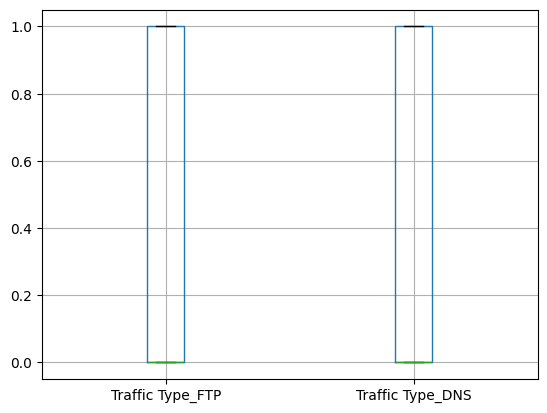

In [85]:
# plot
ax = plt.subplot()
#ax.scatter(y=X_train_enc['Anomaly Scores'],x=X_train_enc['Traffic Type_DNS'],c=y_train_enc, marker='+')
boxplot = X_train_enc.boxplot(column=['Traffic Type_FTP','Traffic Type_DNS'])